In [1]:
import pandas as pd
import numpy as np

import os
import random

from numpy.random import seed

from keras.layers.experimental import preprocessing
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# For reproducible results
seed_value = 1
os.environ['PYTHONHASHSEED'] = str(seed_value)

random.seed(seed_value)

np.random.seed(seed_value)

tf.random.set_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [3]:
OUTPUT_PATH = './Data/output/'

### Import dataset

In [4]:
dataset_raw = pd.read_csv(OUTPUT_PATH + 'CleanData_Population_Schools_SDGs.csv')
dataset_raw['No_of_Schools'] = dataset_raw['SCH_TYPE_PRIVATE'] + dataset_raw['SCH_TYPE_PUBLIC'] + dataset_raw['SCH_TYPE_SUC']
len(dataset_raw)

2482

In [5]:
dataset = dataset_raw.dropna()
len(dataset)

1756

### Preprocess data

In [6]:
SDG = dataset.iloc[:,84:]
SDG['PSGC_BRGY'] = dataset['PSGC_BRGY']

#### 1. Elementary

In [7]:
data_elem = SDG.copy()
data_elem['NUM_SCHOOLS'] = dataset['SCH_CAT_CES'] + dataset['SCH_CAT_ES'] + dataset['SCH_CAT_PS'] + dataset['SCH_CAT_PES']
data_elem['ELEM_POPN'] = dataset['both_age_6_to_12']
len(data_elem)

1756

In [8]:
zero_schools_elem = data_elem[data_elem['NUM_SCHOOLS'] == 0]
data_elem = data_elem[data_elem['NUM_SCHOOLS'] != 0]
data_elem = data_elem.drop(['PSGC_BRGY'], axis=1)
len(data_elem)

1703

#### 2. High School

In [9]:
data_hs = SDG.copy()
data_hs['NUM_SCHOOLS'] = dataset['SCH_CAT_JHS'] + dataset['SCH_CAT_SHS'] + dataset['SCH_CAT_PJHS'] + dataset['SCH_CAT_PSHS']
data_hs['HS_POPN'] = dataset['both_age_13_to_16']
len(data_hs)

1756

In [10]:
zero_schools_hs = data_hs[data_hs['NUM_SCHOOLS'] == 0]
data_hs = data_hs[data_hs['NUM_SCHOOLS'] != 0]
data_hs = data_hs.drop(['PSGC_BRGY'], axis=1)
len(data_hs)

366

#### 3. Merged Elem and High School
For feature selection

In [11]:
data_merged = pd.read_csv(OUTPUT_PATH + 'CleanData_clustering.csv')
data_merged = data_merged.dropna()

### Modelling

In [12]:
training_data, testing_data = train_test_split(data_hs, test_size=0.2, random_state=42)

In [13]:
X_train = training_data.drop(['NUM_SCHOOLS'], axis=1)
y_train = training_data['NUM_SCHOOLS']

X_test = testing_data.drop(['NUM_SCHOOLS'], axis=1)
y_test = testing_data['NUM_SCHOOLS']

In [14]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))

In [15]:
def base_model():
    np.random.seed(1)
    model = Sequential()
    model.add(normalizer)
    model.add(Dense(4, input_dim=2, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam')
#     model.add(Dense(20, activation='tanh', input_dim=5, kernel_initializer='uniform'))
#     model.add(Dense(1, activation='linear', kernel_initializer='uniform'))
    
    model.compile(loss='mse', optimizer='adam')
    return model

In [17]:
model = base_model()
EPOCHS = 200
BATCH_SIZE = 10


callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(X_train, 
                    y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE,
                    validation_split=0.2,
                    callbacks=callback)

Epoch 1/200
24/24 [==============================] - 1s 22ms/step - loss: 1.6115 - val_loss: 1.2852
Epoch 2/200
24/24 [==============================] - 0s 4ms/step - loss: 1.1776 - val_loss: 1.1219
Epoch 3/200
24/24 [==============================] - 0s 5ms/step - loss: 1.1113 - val_loss: 0.9525
Epoch 4/200
24/24 [==============================] - 0s 5ms/step - loss: 0.8881 - val_loss: 0.7909
Epoch 5/200
24/24 [==============================] - 0s 5ms/step - loss: 0.8715 - val_loss: 0.6511
Epoch 6/200
24/24 [==============================] - 0s 5ms/step - loss: 0.6628 - val_loss: 0.5464
Epoch 7/200
24/24 [==============================] - 0s 4ms/step - loss: 0.5122 - val_loss: 0.4729
Epoch 8/200
24/24 [==============================] - 0s 5ms/step - loss: 0.5189 - val_loss: 0.4251
Epoch 9/200
24/24 [==============================] - 0s 5ms/step - loss: 0.4413 - val_loss: 0.3918
Epoch 10/200
24/24 [==============================] - 0s 5ms/step - loss: 0.3327 - val_loss: 0.3667
Epoch 11

24/24 [==============================] - 0s 5ms/step - loss: 0.1352 - val_loss: 0.1777
Epoch 84/200
24/24 [==============================] - 0s 5ms/step - loss: 0.1425 - val_loss: 0.1754
Epoch 85/200
24/24 [==============================] - 0s 5ms/step - loss: 0.2189 - val_loss: 0.1753
Epoch 86/200
24/24 [==============================] - 0s 5ms/step - loss: 0.1401 - val_loss: 0.1751
Epoch 87/200
24/24 [==============================] - 0s 5ms/step - loss: 0.2810 - val_loss: 0.1772
Epoch 88/200
24/24 [==============================] - 0s 6ms/step - loss: 0.1870 - val_loss: 0.1766
Epoch 89/200
24/24 [==============================] - 0s 5ms/step - loss: 0.1355 - val_loss: 0.1760
Epoch 90/200
24/24 [==============================] - 0s 5ms/step - loss: 0.1965 - val_loss: 0.1763
Epoch 91/200
24/24 [==============================] - 0s 5ms/step - loss: 0.1765 - val_loss: 0.1773
Epoch 92/200
24/24 [==============================] - 0s 5ms/step - loss: 0.1372 - val_loss: 0.1753
Epoch 93/200


24/24 [==============================] - 0s 5ms/step - loss: 0.1476 - val_loss: 0.1925
Epoch 165/200
24/24 [==============================] - 0s 5ms/step - loss: 0.0979 - val_loss: 0.1923
Epoch 166/200
24/24 [==============================] - 0s 5ms/step - loss: 0.0997 - val_loss: 0.1918
Epoch 167/200
24/24 [==============================] - 0s 5ms/step - loss: 0.1006 - val_loss: 0.1910
Epoch 168/200
24/24 [==============================] - 0s 5ms/step - loss: 0.1146 - val_loss: 0.1961
Epoch 169/200
24/24 [==============================] - 0s 4ms/step - loss: 0.1374 - val_loss: 0.1919
Epoch 170/200
24/24 [==============================] - 0s 4ms/step - loss: 0.1306 - val_loss: 0.1951
Epoch 171/200
24/24 [==============================] - 0s 5ms/step - loss: 0.1293 - val_loss: 0.1908
Epoch 172/200
24/24 [==============================] - 0s 5ms/step - loss: 0.0884 - val_loss: 0.1928
Epoch 173/200
24/24 [==============================] - 0s 5ms/step - loss: 0.0973 - val_loss: 0.1952
Epoc

In [18]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
171,0.118703,0.192849,171
172,0.117529,0.195204,172
173,0.117881,0.196096,173
174,0.118612,0.196026,174
175,0.117880,0.195640,175


In [19]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

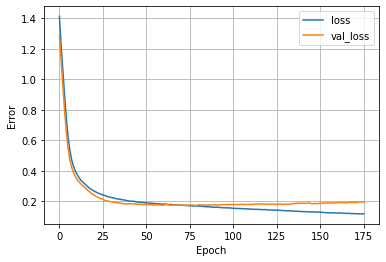

In [20]:
plot_loss(history)

In [21]:
y_pred = model.predict(X_test)

In [22]:
y_pred_round = np.round(y_pred)

In [23]:
accuracy_score(y_test, y_pred_round)

0.7837837837837838

In [24]:
# model.save(OUTPUT_PATH + 'Model_NN_HS')

### PREDICT BRGY WITHOUT SCHOOL

In [25]:
def predict(X_predict):
    y_pred_null = model.predict(X_predict)
    X_predict['Pred_school_num'] = np.round(y_pred_null)
    X_predict['PSGC_BRGY'] = dataset_null['PSGC_BRGY']
    return X_predict

In [26]:
dataset_null = dataset_raw[dataset_raw.isnull().any(axis=1)]
len(dataset_null)

726

In [27]:
X_predict = dataset_null.iloc[:,84:]
X_predict['HS_POPN'] = dataset_null['both_age_13_to_16']

In [28]:
pred_1 = predict(X_predict)
pred_1['PSGC_BRGY'] = dataset_null['PSGC_BRGY']

In [29]:
zero_schools = zero_schools_hs.drop(['NUM_SCHOOLS','PSGC_BRGY'], axis=1)

In [30]:
pred_2 = predict(zero_schools)
pred_2['PSGC_BRGY'] = zero_schools_hs['PSGC_BRGY']

In [31]:
predicted_df = pd.concat([pred_1, pred_2])

In [32]:
len(predicted_df)

2116

In [33]:
predicted_df.to_csv(OUTPUT_PATH + 'Model_NN_Output_HS.csv', index=False)

### FEATURE IMPORTANCE

In [44]:
from sklearn.model_selection import cross_val_score, KFold
from keras.wrappers.scikit_learn import KerasRegressor

import eli5
from eli5.sklearn import PermutationImportance

In [45]:
estimator = KerasRegressor(build_fn=base_model, nb_epoch=EPOCHS, 
                    batch_size=BATCH_SIZE,
                    validation_split=0.2)
kfold = KFold(n_splits=10, random_state=1, shuffle=True)

In [46]:
results = cross_val_score(estimator, X_train, y_train, cv=kfold)

12/12 [==============================] - 0s 816us/step - loss: 1.4270


In [47]:
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -1.81 (0.65) MSE


In [48]:
estimator.fit(X_train, y_train)

96/96 [==============================] - 0s 2ms/step - loss: 5.1113 - val_loss: 4.3918


In [49]:
perm = PermutationImportance(estimator, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

119/119 [==============================] - 0s 999us/step - loss: 3.6782


Weight,Feature
0.1131 ± 0.0511,SDG_Type_Building_Single_Pct
0.0831 ± 0.0330,SDG_Type_Worker_Cle
0.0808 ± 0.0250,SDG_Type_Worker_Pla
0.0632 ± 0.0323,SDG_Households_Drinking_Owned_Faucet_Pct
0.0593 ± 0.0156,SDG_Type_Worker_Tec
0.0555 ± 0.0203,SDG_Type_Worker_Ski
0.0542 ± 0.0212,SDG_Households_Electricity_Light_Pct
0.0464 ± 0.0107,ELEM_POPN
0.0437 ± 0.0268,SDG_Type_Worker_Ser
0.0415 ± 0.0182,SDG_Households_Construction_Material_Concrete_Pct


In [54]:
zero_schools_elem[zero_schools_elem['PSGC_BRGY']== 'PH153812019']

,SDG_Households_Electricity_Light_Pct,SDG_Households_Kerosene_Gass_Light_Pct,SDG_Households_Drinking_Owned_Faucet_Pct,SDG_Households_Drinking_Shared_Faucet_Pct,SDG_Households_Construction_Material_Concrete_Pct,SDG_Building_Tenure_Type_Owned_Pct,SDG_Type_Building_Single_Pct,SDG_Type_Worker_Man,SDG_Type_Worker_Pro,SDG_Type_Worker_Tec,...,SDG_Type_Worker_Ser,SDG_Type_Worker_Ski,SDG_Type_Worker_Cra,SDG_Type_Worker_Pla,SDG_Type_Worker_Ele,SDG_Type_Worker_Arm,SDG_less_than_54_sqft,PSGC_BRGY,NUM_SCHOOLS,ELEM_POPN
